## CSUS - CSc 177-02 Data Warehousing and Data Mining - Final Project:   
### Predicting Top 10 songs on Spotify's Regional Daily Top 200 Charts  

**Group members: Aaron Enberg, Nima Sarrafzadeh, Kyne Liu**  
**Professor: Haiquan (Victor) Chen**

In [39]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import (
    preprocessing,  
    metrics
)
from imblearn.under_sampling import AllKNN
import sklearn.feature_extraction.text as sk_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
pd.set_option('display.max_colwidth', -1)

In [2]:
daily_spotify = pd.read_csv('./data/data.csv')
daily_spotify.columns = ['position', 'track_name', 'artist', 'streams', 'url', 'date', 'region']

In [3]:
print(daily_spotify.shape)
print(daily_spotify.dtypes)

(3441197, 7)
position      int64 
track_name    object
artist        object
streams       int64 
url           object
date          object
region        object
dtype: object


In [4]:
daily_spotify.head()

,position,track_name,artist,streams,url,date,region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAOSC1qTfo,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyVjxPOHdq,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul3ywMe46,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtcMZ4S4bO,2017-01-01,ec


In [5]:
daily_spotify['region'].unique()

array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee',
       'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch',
       'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se',
       'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg',
       'id', 'do', 'lu', 'gb', 'global', 'py', 'au', 'lv', 'gr', 'hk'],
      dtype=object)

In [6]:
daily_spotify['track_name_by_artist'] = daily_spotify.track_name.str.cat(daily_spotify.artist, sep=' ')

In [7]:
df_initial_streams_by_region = daily_spotify.groupby(
    ['track_name_by_artist', 'date', 'region'],
    as_index=False)['streams'].sum().drop_duplicates(['track_name_by_artist', 'region'], keep='first')

In [8]:
# what are the streams count for the first day in each region?
df_initial_streams_by_region.head(n=10)

,track_name_by_artist,date,region,streams
0,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",2017-01-08,pl,3547
1,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",2017-01-08,tr,3764
2,"""Read All About It, Pt. III"" Emeli Sandé",2017-02-12,dk,6967
3,"""Read All About It, Pt. III"" Emeli Sandé",2017-02-14,no,9925
4,"""Read All About It, Pt. III"" Emeli Sandé",2017-02-14,se,17307
5,"""Read All About It, Pt. III"" Emeli Sandé",2017-10-09,be,3075
6,"""Read All About It, Pt. III"" Emeli Sandé",2017-10-09,cz,1338
15,#99 JVG,2017-01-01,fi,4522
21,#Askip Black M,2017-01-01,fr,14496
39,#Biziz - feat. Lil Bege Reynmen,2017-09-08,tr,10800


In [9]:
# the first day a song hits top 200, how many streams does it rack up (sum over all regions on that day)?
# NOTE: this is NOT all of the streams for the first day of EVERY region a song ranks in.
df_streams_first_day = daily_spotify.groupby(
    ['track_name_by_artist', 'date'],
    as_index=False)['streams'].sum().drop_duplicates(['track_name_by_artist'], keep='first')

In [10]:
df_streams_first_day.head()

,track_name_by_artist,date,streams
0,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",2017-01-08,7311
1,"""Read All About It, Pt. III"" Emeli Sandé",2017-02-12,6967
8,#99 JVG,2017-01-01,4522
14,#Askip Black M,2017-01-01,14496
32,#Biziz - feat. Lil Bege Reynmen,2017-09-08,10800


In [11]:
df_streams_first_day.drop(['date'], axis=1, inplace=True)
df_streams_first_day.set_index('track_name_by_artist', inplace=True)
df_streams_first_day.columns = ['streams_first_day']

In [12]:
df_streams_first_day.head()

,streams_first_day
track_name_by_artist,
"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",7311
"""Read All About It, Pt. III"" Emeli Sandé",6967
#99 JVG,4522
#Askip Black M,14496
#Biziz - feat. Lil Bege Reynmen,10800


In [13]:
df_streams_by_country = daily_spotify.groupby(
    ['track_name_by_artist', 'region', 'date', 'position'],
    as_index=False)['streams'].sum()

In [14]:
df_streams_by_country.head(n=10)

,track_name_by_artist,region,date,position,streams
0,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",pl,2017-01-08,185,3547
1,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",tr,2017-01-08,198,3764
2,"""Read All About It, Pt. III"" Emeli Sandé",be,2017-10-09,186,3075
3,"""Read All About It, Pt. III"" Emeli Sandé",be,2017-10-15,192,3053
4,"""Read All About It, Pt. III"" Emeli Sandé",be,2017-10-16,147,3330
5,"""Read All About It, Pt. III"" Emeli Sandé",be,2017-10-22,182,3179
6,"""Read All About It, Pt. III"" Emeli Sandé",be,2017-10-23,159,3334
7,"""Read All About It, Pt. III"" Emeli Sandé",cz,2017-10-09,184,1338
8,"""Read All About It, Pt. III"" Emeli Sandé",cz,2017-10-15,190,1222
9,"""Read All About It, Pt. III"" Emeli Sandé",cz,2017-10-16,163,1527


In [15]:
# the first day a song hits the top 200, which countries' charts does it appear on? 
df_country_initial_appear = df_streams_by_country.drop_duplicates(
    ['track_name_by_artist', 'region'], keep='first')

df_country_initial_appear.drop(['position', 'streams'], axis=1, inplace=True)

/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [16]:
df_country_initial_appear.head()

,track_name_by_artist,region,date
0,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",pl,2017-01-08
1,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",tr,2017-01-08
2,"""Read All About It, Pt. III"" Emeli Sandé",be,2017-10-09
7,"""Read All About It, Pt. III"" Emeli Sandé",cz,2017-10-09
12,"""Read All About It, Pt. III"" Emeli Sandé",dk,2017-02-12


In [17]:
df_country_initial_appear = df_country_initial_appear.groupby(
    ['track_name_by_artist', 'date']
)['region'].apply(list).to_frame().reset_index().drop_duplicates(['track_name_by_artist'], keep='first')

In [18]:
df_country_initial_appear['regions_stringified'] = df_country_initial_appear['region'].apply(
    lambda x: ' '.join(map(str, x)))
corpus = list(df_country_initial_appear['regions_stringified'])

vectorizer = sk_text.CountVectorizer()
matrix = vectorizer.fit_transform(corpus)

In [19]:
df_streams_by_country['top10'] = np.where(df_streams_by_country['position'] <= 10, 1, 0)
df_streams_by_country['top10'].value_counts()

0    3244032
1    196508 
Name: top10, dtype: int64

In [20]:
df_top10 = df_streams_by_country.drop_duplicates(['track_name_by_artist', 'top10'])
df_top10 = df_top10.sort_values(['track_name_by_artist', 'top10'], inplace=False)
df_top10.drop_duplicates(['track_name_by_artist'], keep='last', inplace=True)
df_top10.reset_index(level=0, drop=True, inplace=True)
df_top10.drop(['track_name_by_artist', 'region', 'position', 'date', 'streams'], axis=1, inplace=True)
df_top10['top10'].value_counts()

0    18576
1    1346 
Name: top10, dtype: int64

In [21]:
# 0 = song did NOT hit 1-10 chart position | # 1 = song hit 1-10 chart position
df_top10.head()

,top10
0,0
1,0
2,0
3,0
4,0


In [22]:
# max number of streams for a region, considering a song's entire lifetime on that region's chart
df_total_streams_region = df_streams_by_country.pivot_table(
    index=['track_name_by_artist'], 
    columns='region', 
    values='streams', 
    aggfunc=sum, 
    fill_value=0)
df_total_streams_region.reset_index(level=0, inplace=True)

max_daily_streams_by_region = df_total_streams_region.max().to_frame().T
max_daily_streams_by_region.drop('track_name_by_artist', axis=1, inplace=True)

In [23]:
max_daily_streams_by_region.head()

region,ar,at,au,be,bo,br,ca,ch,cl,co,...,pt,py,se,sg,sk,sv,tr,tw,us,uy
0,53340691,5730722,51946735,11255872,2647248,97680541,47971559,9933459,43449451,15677258,...,8607798,3858867,63869649,15635592,1266491,2022375,18442317,7767759,339677217,3583076


In [24]:
def div_streams(i, j):
    return df_initial_streams_by_region['streams'][i] / max_daily_streams_by_region.iloc[0, j]

percentages = []
for idx, region in df_initial_streams_by_region['region'].iteritems():
        j = max_daily_streams_by_region.columns.values.tolist().index(str(region))
        percentages.append(div_streams(idx, j))

In [25]:
regional_percentage_max_daily_streams = pd.DataFrame(percentages, index=df_initial_streams_by_region.index)
regional_percentage_max_daily_streams.columns = ['percentage_reg_max_daily_streams']

In [26]:
df_to_pivot = df_initial_streams_by_region.join(regional_percentage_max_daily_streams, how='inner')
df_to_pivot.drop([ 'date', 'streams'], axis=1, inplace=True)

In [27]:
df_pct_reg_max_daily_streams = df_to_pivot.pivot_table(
    index=['track_name_by_artist'], 
    columns='region', 
    values='percentage_reg_max_daily_streams',
    fill_value=0)

In [28]:
df_pct_reg_first_day = df_pct_reg_max_daily_streams.join(df_streams_first_day, how='inner')

In [29]:
df_pct_reg_first_day.head()

,ar,at,au,be,bo,br,ca,ch,cl,co,...,py,se,sg,sk,sv,tr,tw,us,uy,streams_first_day
track_name_by_artist,,,,,,,,,,,,,,,,,,,,,
"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000204,0.0,0.0,0.0,7311
"""Read All About It, Pt. III"" Emeli Sandé",0.0,0.0,0.0,0.000273,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000271,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,6967
#99 JVG,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4522
#Askip Black M,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,14496
#Biziz - feat. Lil Bege Reynmen,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000586,0.0,0.0,0.0,10800


In [30]:
df_initial_regions = pd.DataFrame(matrix.toarray(), 
                  index=df_pct_reg_first_day.index, 
                  columns=vectorizer.get_feature_names())

df_initial_regions = df_initial_regions.add_prefix('first_appear_')

In [31]:
df = df_initial_regions.join(df_pct_reg_first_day, how='inner')

In [32]:
df.head()

,first_appear_ar,first_appear_at,first_appear_au,first_appear_be,first_appear_bo,first_appear_br,first_appear_ca,first_appear_ch,first_appear_cl,first_appear_co,...,py,se,sg,sk,sv,tr,tw,us,uy,streams_first_day
track_name_by_artist,,,,,,,,,,,,,,,,,,,,,
"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000204,0.0,0.0,0.0,7311
"""Read All About It, Pt. III"" Emeli Sandé",0,0,0,0,0,0,0,0,0,0,...,0.0,0.000271,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,6967
#99 JVG,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4522
#Askip Black M,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,14496
#Biziz - feat. Lil Bege Reynmen,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000586,0.0,0.0,0.0,10800


In [33]:
y = df_top10['top10']
y.value_counts()

0    18576
1    1346 
Name: top10, dtype: int64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15937, 109)
(3985, 109)
(15937,)
(3985,)


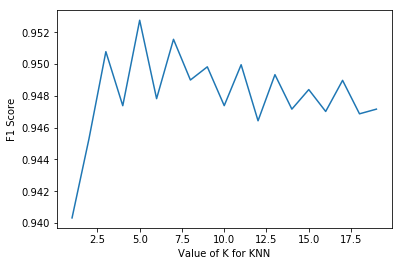

In [36]:
# Create the classifier
k_range = list(range(1, 20))
params = {'n_neighbors': k_range}

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', 
                           algorithm='auto', leaf_size=30, 
                           p=2, metric='minkowski', 
                           metric_params=None, n_jobs=1)

std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))

import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 Score')
plt.show()

In [37]:
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98      3714
          1       0.84      0.41      0.55       271

avg / total       0.95      0.95      0.95      3985



In [40]:
svm = SVC()
svm_params = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}

svm_grid_search_cv = GridSearchCV(svm, svm_params, 
                                  cv=10, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')

# undersampling by prototype selection with cleaning heuristcs
ak = AllKNN(ratio='auto', kind_sel='mode', n_neighbors=3)

X_train_resampled, y_train_resampled = ak.fit_sample(X_train, y_train)

reduction_str = ('Reduced majority class by {:.2f}%'.format(
    100 * (1 - float(len(X_train_resampled)) / len(X_train))))
print(reduction_str)
print(sorted(Counter(y_train_resampled).items()))

res_std_scaler = preprocessing.StandardScaler()
X_train_res_scaled = res_std_scaler.fit_transform(X_train_resampled)
X_test_res_scaled = res_std_scaler.transform(X_test)

svm_grid_search_cv.fit(X_train_res_scaled, y_train_resampled)
y_pred = svm_grid_search_cv.predict(X_test_res_scaled)

print(svm_grid_search_cv.best_score_)
print(svm_grid_search_cv.best_params_)
print(svm_grid_search_cv.best_estimator_)
print(metrics.classification_report(y_test, y_pred))

Reduced majority class by 6.34%
[(0, 13851), (1, 1075)]
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished


0.9485042052121314
{'gamma': 0.001, 'C': 1000, 'kernel': 'rbf'}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3714
          1       0.73      0.53      0.62       271

avg / total       0.95      0.96      0.95      3985



In [41]:
log_reg = LogisticRegressionsticRegression()
log_reg_params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

log_reg_grid_search_cv = GridSearchCV(log_reg, log_reg_params, 
                                  cv=10, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')

# undersampling by prototype selection with cleaning heuristcs
ak = AllKNN(ratio='auto', kind_sel='mode', n_neighbors=3)

X_train_resampled, y_train_resampled = ak.fit_sample(X_train, y_train)

reduction_str = ('Reduced majority class by {:.2f}%'.format(
    100 * (1 - float(len(X_train_resampled)) / len(X_train))))
print(reduction_str)
print(sorted(Counter(y_train_resampled).items()))

res_std_scaler = preprocessing.StandardScaler()
X_train_res_scaled = res_std_scaler.fit_transform(X_train_resampled)
X_test_res_scaled = res_std_scaler.transform(X_test)

log_reg_grid_search_cv.fit(X_train_res_scaled, y_train_resampled)
y_pred = svm_grid_search_cv.predict(X_test_res_scaled)

print(log_reg_grid_search_cv.best_score_)
print(log_reg_grid_search_cv.best_params_)
print(log_reg_grid_search_cv.best_estimator_)
print(metrics.classification_report(y_test, y_pred))

Reduced majority class by 6.34%
[(0, 13851), (1, 1075)]
Fitting 10 folds for each of 14 candidates, totalling 140 fits


/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

0.9447722915013359
{'C': 10, 'penalty': 'l2'}
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3714
          1       0.73      0.53      0.62       271

avg / total       0.95      0.96      0.95      3985



##### Improve the base model  by using Grid Search with cross-validation, and resampling the training set

In [50]:
# Create the classifier
params = {'n_neighbors': k_range, 'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Grid search to find best parameters for k-nearest neighbors
knn_grid_search_cv = GridSearchCV(knn, params, 
                                  cv=10, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')

# undersampling by prototype selection with cleaning heuristcs
ak = AllKNN(ratio='auto', kind_sel='mode', n_neighbors=3)

X_train_resampled, y_train_resampled = ak.fit_sample(X_train, y_train)

reduction_str = ('Reduced majority class by {:.2f}%'.format(
    100 * (1 - float(len(X_train_resampled)) / len(X_train))))
print(reduction_str)
print(sorted(Counter(y_train_resampled).items()))

res_std_scaler = preprocessing.StandardScaler()
X_train_res_scaled = res_std_scaler.fit_transform(X_train_resampled)
X_test_res_scaled = res_std_scaler.transform(X_test)

knn_grid_search_cv.fit(X_train_res_scaled, y_train_resampled)
y_pred = knn_grid_search_cv.predict(X_test_res_scaled)

print(knn_grid_search_cv.best_score_)
print(knn_grid_search_cv.best_params_)
print(knn_grid_search_cv.best_estimator_)
print(metrics.classification_report(y_test, y_pred))

Reduced majority class by 6.34%
[(0, 13851), (1, 1075)]
Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed: 71.4min finished


0.9495582944656619
{'weights': 'uniform', 'p': 1, 'n_neighbors': 7}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=1,
           weights='uniform')
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      3714
          1       0.80      0.49      0.61       271

avg / total       0.95      0.96      0.95      3985

